
1. The parameters that determine the exact form of a binary black hole waveform are the masses, sky location, **distance**, black hole spins, binary orientation angle, gravitational wave polarisation, time of arrival, and phase at coalescence (merger). These parameters (15 in total) have been randomised according to astrophysically motivated prior distributions and used to generate the simulated signals present in the data, but are not provided as part of the competition data.

2. The integrated signal-to noise ratio (SNR) is classically the most informative measure of how detectable a signal is and a typical level of detectability is when this integrated SNR exceeds ~8. This shouldn't confused with the instantaneous SNR - the factor by which the signal rises above the noise - and in nearly all cases the (unlike the first gravitational wave detection GW150914) these signals are not visible by eye in the time series.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import random

import sys

import pycbc
from pycbc.waveform import get_td_waveform
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.noise.gaussian import noise_from_psd
from pycbc.waveform import td_approximants
from pycbc.psd import welch, interpolate
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.detector import Detector
from pycbc.types import TimeSeries

from copy import deepcopy
import time

import torch
from scipy.signal.windows import tukey
from nnAudio.Spectrogram import CQT1992v2


import math
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
def get_train_file_path(image_id):
    return "{}/train/{}/{}/{}/{}.npy".format(input_data_folder,
        image_id[0], image_id[1], image_id[2], image_id)
def get_test_file_path(image_id):
    return "{}/test/{}/{}/{}/{}.npy".format(input_data_folder,
        image_id[0], image_id[1], image_id[2], image_id)

In [5]:
gdrive='../../data/'
input_data_folder = gdrive + "/g2net-gravitational-wave-detection"
train_df = pd.read_csv(input_data_folder + '/training_labels.csv')
oof_pred_df = pd.read_csv(gdrive +"/oof_8803.csv")
train_df = train_df.merge(oof_pred_df[["id","prediction"]],on="id")
train_df["prediction"] = train_df["prediction"].rank(pct=True)
train_df["path"] = train_df["id"].apply(get_train_file_path)
train_df

,id,target,prediction,path
0,00000e74ad,1,0.573727,../../data//g2net-gravitational-wave-detection...
1,00001f4945,0,0.287620,../../data//g2net-gravitational-wave-detection...
2,0000661522,0,0.270036,../../data//g2net-gravitational-wave-detection...
3,00007a006a,0,0.207989,../../data//g2net-gravitational-wave-detection...
4,0000a38978,1,0.561720,../../data//g2net-gravitational-wave-detection...
...,...,...,...,...
559995,ffff9a5645,1,0.142170,../../data//g2net-gravitational-wave-detection...
559996,ffffab0c27,0,0.144139,../../data//g2net-gravitational-wave-detection...
559997,ffffcf161a,1,0.733809,../../data//g2net-gravitational-wave-detection...
559998,ffffd2c403,0,0.321532,../../data//g2net-gravitational-wave-detection...


In [6]:
train_neg_df = train_df.query("target==0").copy()
train_neg_df.head()

,id,target,prediction,path
1,00001f4945,0,0.287620,../../data//g2net-gravitational-wave-detection...
2,0000661522,0,0.270036,../../data//g2net-gravitational-wave-detection...
3,00007a006a,0,0.207989,../../data//g2net-gravitational-wave-detection...
6,0000c3b9c9,0,0.499568,../../data//g2net-gravitational-wave-detection...
10,000118b40d,0,0.339396,../../data//g2net-gravitational-wave-detection...


In [7]:
train_pos_df = train_df.query("target==1").copy()
train_pos_df.head()

,id,target,prediction,path
0,00000e74ad,1,0.573727,../../data//g2net-gravitational-wave-detection...
4,0000a38978,1,0.561720,../../data//g2net-gravitational-wave-detection...
5,0000bb9f3e,1,0.835591,../../data//g2net-gravitational-wave-detection...
7,0000d61b7b,1,0.930327,../../data//g2net-gravitational-wave-detection...
8,0001016d12,1,0.028005,../../data//g2net-gravitational-wave-detection...


In [8]:
train_neg_df.shape

(280070, 4)

# Get Noise PSD

In [11]:
# get_all_psd
from tqdm import tqdm
from collections import defaultdict
psds = defaultdict(list)

def get_psd(wave):
    ts = pycbc.types.TimeSeries(wave, epoch=0, delta_t=1.0/2048)
    delta_t = 1.0/2048
    seg_len = int(1 / delta_t)#1 second
    seg_stride = int(seg_len / 2)#50% overlap
    estimated_psd = interpolate(welch(ts,
                                      seg_len=seg_len,
                                      seg_stride=seg_stride), .5)
    return estimated_psd

for idx in tqdm(range(1000)):
    idx = np.random.randint(low=0, high=len(train_neg_df)-1)
    path = train_neg_df.iloc[idx,-1]
    waves = np.load(path)
    for i in range(3):
#         sample_ts = pycbc.types.TimeSeries(waves[i],epoch=0, delta_t=1/2048)
#         #sample_ts = sample_ts.highpass_fir(15,order=8)
#         psd = sample_ts.psd(0.25)
#         psd = interpolate(psd, delta_f=.5)
        psd =  get_psd(waves[i])
        psds[i].append(psd)

IndexError: list index out of range

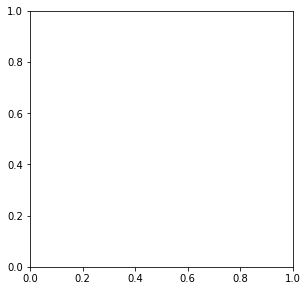

In [10]:
sites=["H1","L1","V1"]
plt.figure(figsize=(16,16))
for i in range(9):
    plt.subplot(3,3,i+1)
    for j in range(3):
        psd = psds[j][i]
        plt.loglog(psd.sample_frequencies, psd.data, label=sites[j])
    plt.legend()
    plt.vlines(x=60,ymin=min(psd.data), ymax=max(psd.data),alpha=0.3)
plt.suptitle("H1")
plt.show()

## Calculate average noise psd

In [ ]:
psds_mean = {}
for i in range(3):
    all_psd = None
    for j in range(len(psds[i])):
        if all_psd is None:
            all_psd = psds[i][j].data
        else:
            all_psd = all_psd + psds[i][j].data
    psd_mean = all_psd / len(psds[i])
    psd_mean = pycbc.types.FrequencySeries(psd_mean, delta_f=.5, epoch=0)
    psds_mean[i] = psd_mean

In [ ]:
sites = ("H1",'L1',"V1")
plt.figure(figsize=(4,4))
for i in range(3):
    psd = psds_mean[i]
    plt.loglog(psd.sample_frequencies, psd.data, label=sites[i])
    plt.vlines(x=60,ymin=min(psd.data), ymax=max(psd.data),alpha=0.3)
plt.legend()
plt.suptitle("Average psd")
plt.show()

# Noise Generation

In [ ]:
from pycbc.noise.gaussian import noise_from_psd

In [ ]:
# %%timeit
# noise_H1_sim = noise_from_psd(4096, 1/2048, psds_mean[0], seed=1)
# noise_L1_sim = noise_from_psd(4096, 1/2048, psds_mean[1], seed=2)
# noise_V1_sim = noise_from_psd(4096, 1/2048, psds_mean[2], seed=3)

In [ ]:
# psds_mean[0].delta_t

In [ ]:
plt.figure(figsize=(16,16))
for i in range(9):
    noise_H1_sim = noise_from_psd(4096, 1/2048, psds_mean[0])
    noise_L1_sim = noise_from_psd(4096, 1/2048, psds_mean[1])
    noise_V1_sim = noise_from_psd(4096, 1/2048, psds_mean[2])

    psd_H1_sim = get_psd(noise_H1_sim) # interpolate(noise_H1_sim.psd(0.25), delta_f=.5)
    psd_L1_sim = get_psd(noise_L1_sim) # interpolate(noise_L1_sim.psd(0.25), delta_f=.5)
    psd_V1_sim = get_psd(noise_V1_sim) # interpolate(noise_V1_sim.psd(0.25), delta_f=.5)

    plt.subplot(3,3,i+1)
    plt.loglog(psd_H1_sim.sample_frequencies, psd_H1_sim.data, label=sites[0])
    plt.loglog(psd_L1_sim.sample_frequencies, psd_L1_sim.data, label=sites[1])
    plt.loglog(psd_V1_sim.sample_frequencies, psd_V1_sim.data, label=sites[2])
    plt.vlines(x=60,ymin=min(psd.data), ymax=max(psd.data),alpha=0.3)
    plt.legend()
plt.show()

In [ ]:
psds_sim = defaultdict(list)
for idx in tqdm(range(1000)):
    noise_H1_sim = noise_from_psd(4096, 1/2048, psds_mean[0], seed=i*3+1)
    noise_L1_sim = noise_from_psd(4096, 1/2048, psds_mean[1], seed=i*3+2)
    noise_V1_sim = noise_from_psd(4096, 1/2048, psds_mean[2], seed=i*3+3)
    waves = np.array([noise_H1_sim, noise_L1_sim, noise_V1_sim])
    for i in range(3):
#         sample_ts = pycbc.types.TimeSeries(waves[i],epoch=0, delta_t=1/2048)
#         #sample_ts = sample_ts.highpass_fir(15,order=8)
#         psd = sample_ts.psd(0.25)
#         psd = interpolate(psd, delta_f=.5)
        psd = get_psd(waves[i])
        psds_sim[i].append(psd)

In [ ]:
len(psds_sim[0])

In [ ]:
psds_sim_mean = {}
for i in range(3):
    all_psd = None
    for j in range(len(psds_sim[i])):
        if all_psd is None:
            all_psd = psds_sim[i][j].data
        else:
            all_psd = all_psd + psds_sim[i][j].data
    psd_sim_mean = all_psd / len(psds_sim[i])
    psd_sim_mean = pycbc.types.FrequencySeries(psd_sim_mean, delta_f=.5, epoch=0)
    psds_sim_mean[i] = psd_sim_mean

In [ ]:
sites = ("H1",'L1',"V1")
plt.figure(figsize=(4,4))
for i in range(3):
    psd = psds_sim_mean[i]
    plt.loglog(psd.sample_frequencies, psd.data, label=sites[i] + " sim")
    plt.vlines(x=60,ymin=min(psd.data), ymax=max(psd.data),alpha=0.3)
plt.legend()
plt.suptitle("Average psd simulation")
plt.show()

In [ ]:
sites = ("H1",'L1',"V1")
plt.figure(figsize=(4,4))
for i in range(3):
    psd = psds_mean[i]
    plt.loglog(psd.sample_frequencies, psd.data, label=sites[i])
    plt.vlines(x=60,ymin=min(psd.data), ymax=max(psd.data),alpha=0.3)
plt.legend()
plt.suptitle("Average psd")
plt.show()

# GW Generation

## Plot Function

In [ ]:
def plot_single_detector(noise, signal, combined, suptitle="", do_wave_plot=True):
    if do_wave_plot:
        plt.figure(figsize=(20,5))
        plt.subplot(1,3,1)
        plt.plot(noise.sample_times,noise)
        plt.title("noise")

        plt.subplot(1,3,2)
        plt.plot(signal.sample_times,signal)
        plt.title("signal")

        plt.subplot(1,3,3)
        plt.plot(combined.sample_times,combined)
        plt.title("synthetic signal")

        plt.suptitle(suptitle)
        plt.show()

    plt.figure(figsize=(20,5))
    for i,(data, title) in enumerate([(combined, 'Synthetic Signal'),
                                      (noise, 'Noise')]):
        plt.subplot(1,2,i+1)

        t, f, p = data.whiten(0.25,0.25).qtransform(delta_t=noise.delta_t,
                                  logfsteps=100,
                                  qrange=(8, 8),
                                  frange=(20, 512))
        plt.title(title)
        plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        plt.yscale('log')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
    plt.suptitle(suptitle)
    plt.show()    

def plot_CQT_sep(waves_image, waves_sig_image, title):
    plt.figure(figsize=(18,6))
    sites = ("H1",'L1',"V1")
    for i in range(3):
        plt.subplot(1,6,i*2+1)
        plt.imshow(np.flipud(waves_image[i]))
        plt.title(sites[i] + " Original")
        plt.subplot(1,6,i*2+2)
        plt.imshow(np.flipud(waves_sig_image[i]))
        plt.title(sites[i] + " with signal")
    plt.suptitle(title)
    plt.show()

def plot_CQT_together(waves_image, waves_sig_image, title):
    waves_image_norm = waves_image - waves_image.min()
    waves_image_norm = waves_image_norm / waves_image_norm.max()
    waves_sig_image_norm = waves_sig_image - waves_sig_image.min()
    waves_sig_image_norm = waves_sig_image_norm / waves_sig_image_norm.max()
    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)))
    plt.title("original")
    plt.subplot(1,2,2)
    plt.imshow(np.flipud(waves_sig_image_norm.transpose(1,2,0)))
    plt.title("with signal")
    plt.suptitle(title)
    plt.show()    


Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=950, hop_length=64)
Q_TRANSFORM_a = CQT1992v2(sr=2048, fmin=20, fmax=1000, window='flattop', bins_per_octave=48, 
                          filter_scale=0.25, hop_length=8)
def get_image(waves):
    waves = torch.from_numpy(waves)
    image = Q_TRANSFORM_a(waves).squeeze().numpy()
    return image 

In [ ]:
from pycbc.waveform import td_approximants, fd_approximants
print(td_approximants())

## Signal Generation Function

In [ ]:
DET_H1 = Detector('H1')
DET_L1 = Detector('L1')
DET_V1 = Detector('V1')
def pick_4096(signal):
    signal = signal.data
    signal = signal[-4096:]
    remain_len = 4096 - len(signal)
    if remain_len > 0:
        signal = np.pad(signal, (remain_len,0), mode='constant')
    return TimeSeries(signal, delta_t=1/2048)


def generate_signal(param_dict):
    try:
        hp, hc = get_td_waveform(approximant=param_dict['tmp'],
                                  delta_t = 1/2048,
                                  mass1=param_dict['m1'],
                                  mass2=param_dict['m2'],
                                  spin1z = param_dict['s1'],
                                  spin2z = param_dict['s2'],
                                  coa_phase=param_dict['cp'],
                                  inclination=param_dict['inc'],
                                  distance=param_dict['dis'],
                                  f_lower=param_dict['fl']
                                )
    except:
        hp, hc = get_td_waveform(approximant='IMRPhenomPv2',
                                  delta_t = 1/2048,
                                  mass1=param_dict['m1'],
                                  mass2=param_dict['m2'],
                                  spin1z = param_dict['s1'],
                                  spin2z = param_dict['s2'],
                                  coa_phase=param_dict['cp'],
                                  inclination=param_dict['inc'],
                                  distance=param_dict['dis'],
                                  f_lower=param_dict['fl']
                                )
        
    signal_h1 = DET_H1.project_wave(hp, hc,  param_dict['ra'], param_dict['dec'], param_dict['pol'])
    signal_l1 = DET_L1.project_wave(hp, hc,  param_dict['ra'], param_dict['dec'], param_dict['pol'])
    signal_v1 = DET_V1.project_wave(hp, hc,  param_dict['ra'], param_dict['dec'], param_dict['pol'])
    
    signal_h1 = pick_4096(signal_h1)
    signal_l1 = pick_4096(signal_l1)
    signal_v1 = pick_4096(signal_v1)
    return signal_h1, signal_l1, signal_v1

def get_random_param(seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    
    tmp = 'SEOBNRv4_opt'
#     m1 = np.random.uniform(61,50)
#     p = np.random.uniform(0.2,1)
#     m2 = m1 * p
    m1 = np.random.uniform(10,50)
    m2 = np.random.uniform(10,50)
    if m1 < m2:
        m1, m2 = m2, m1
    distance = np.random.uniform(100,1000)

    spin1z = np.random.uniform(0, 0.998)
    spin2z = np.random.uniform(0, 0.998)
    # the coa_phase and the inclination are the
    # two angles that specify the location in the sky of the
    # detector as seen from this source frame. Their values
    # are sampled jointly from a uniform distribution over
    # a sphere.
    coa_phase = np.random.random() * np.pi * 2
    inclination = np.arccos(1 - 2 * np.random.random())
    
    f_lower = np.random.uniform(15, 25)
    # The right ascension of declination defing the position of the source in the sky. 
    # Both values are sampled together from a uniform distribution over the sky.
    ran1, ran2 = np.random.random(2)
    ra  = 2 * np.pi * (ran1 - 0.5)
    dec = np.arcsin(2.*(ran2-0.5)) # Barry Carter
    polarization = np.random.uniform(0, math.pi)

    d = dict(
        tmp=tmp,
        m1=m1,
        m2=m2,
        s1=spin1z,
        s2=spin2z,
        cp=coa_phase,
        dis=distance,
        inc=inclination,
        fl=f_lower,
        ra=ra,
        dec=dec,
        pol=polarization,
    )
    return d

from pycbc.filter import sigma
def transform_signal(signal, psd, snrp, dt):
    # scale the template so that it would have SNR 1 in this data
    signal /= sigma(signal, psd=psd)
    # Scale the template amplitude and phase to the peak value
    if snrp != 1:
        signal = (signal.to_frequencyseries() * snrp).to_timeseries()
    signal = signal.data
    shift_val = int(2048 * dt) # dt is in second
    if shift_val > 0:
        signal = np.pad(signal[shift_val:], (0,shift_val), mode="constant")
    return signal

def get_title(snrp, dt, gen_dict):
    title= "snr_{:.1f}".format(snrp)
    title= title + "@" + "dt_{:.1f}".format(dt)
    for key, val in gen_dict.items():
        if isinstance(val,str):
            title = title + "@{}_{}".format(key,val[:3])
        else:
            title = title + "@{}_{:.1f}".format(key,val)
    return title

## Signal Generation

In [ ]:
avr_w = torch.load("./avr_w.pth")
window = torch.FloatTensor(tukey(4096+2*2048,0.5))
def process_wave(waves, window, avr_w):
    c = torch.FloatTensor(waves)
    c = torch.cat([-c.flip(-1)[:,4096-2049:-1]+2*c[:,0].unsqueeze(-1),c,
                                      -c.flip(-1)[:,1:2049]+2*c[:,-1].unsqueeze(-1)],1)    
    c = torch.fft.ifft(torch.fft.fft((1e20*c*window))/avr_w).real[:,2048:-2048]
    return c.numpy()

In [ ]:
from scipy import signal
asd_dct = np.load("./design_curves_tukey_0.2.npy")
def process_wave_a(waves,design_curves):
    n = waves.shape[-1]
    waves = torch.tensor(waves)
    waves = waves * signal.windows.tukey(waves.shape[1],0.2)
    
    spec = torch.fft.fft(waves)
    dc_len = design_curves.shape[-1]
    whitened = torch.real(torch.fft.ifft(spec[:, :dc_len] / design_curves, n=n))
    whitened *= np.sqrt(n / 2)
    whitened /= torch.max(torch.abs(whitened), axis=1)[0].reshape(waves.shape[0], 1)
    return whitened.to(dtype=torch.float32).numpy()

In [ ]:
gen_dict_default=dict(
    tmp='SEOBNRv4_opt',
    m1=24.1,
    m2=22.3,
    s1=.4,
    s2=.3,
    cp=6.1,
    dis=1,
    inc=.8,
    fl=23.4,
    ra=1.1,
    dec=-0.9,
    pol=0.6,
)

snrp = 7 # np.random.uniform(4,10)
dt=0.5 # second
title = get_title(snrp, dt, gen_dict_default)
print(title)

In [ ]:
hp, hc = get_td_waveform(approximant=gen_dict_default['tmp'],
                            delta_t = 1/2048,
                            mass1=gen_dict_default['m1']+10,
                            mass2=gen_dict_default['m2'],
                            spin1z = gen_dict_default['s1'],
                            spin2z = gen_dict_default['s2'],
                            coa_phase=gen_dict_default['cp'],
                            inclination=gen_dict_default['inc'],
                            f_lower=gen_dict_default['fl']
                        )

In [ ]:
# get signal
signal_h1, signal_l1, signal_v1 = generate_signal(gen_dict_default)

In [ ]:
print(title)
plt.figure(figsize=(12,4))
plt.plot(signal_h1.sample_times, signal_h1.data, label="H1")
plt.plot(signal_l1.sample_times, signal_l1.data, label="L1")
plt.plot(signal_v1.sample_times, signal_v1.data, label="V1")
plt.legend()
plt.show()

In [ ]:
# signal befor injection
print(title)
snrp=10
signal_h1_transformed = transform_signal(signal_h1, psds_mean[0], snrp=snrp, dt=dt)
signal_l1_transformed = transform_signal(signal_l1, psds_mean[1], snrp=snrp, dt=dt)
signal_v1_transformed = transform_signal(signal_v1, psds_mean[2], snrp=snrp, dt=dt)
signal_transformed = np.array([signal_h1_transformed, signal_l1_transformed, signal_v1_transformed])

plt.figure(figsize=(12,4))
for i in range(3):
    plt.plot(signal_transformed[i], label = sites[i])
plt.legend()
plt.show()

In [ ]:
# inject signal
waves = np.load(train_neg_df.iloc[0,-1])
waves_sig = (waves * 1e20) + (signal_transformed * 1e20).astype(np.float16)
waves_sig.shape

In [ ]:
# Whitening and CQT transform
waves_whiten = process_wave_a(waves, asd_dct)
waves_sig_whiten = process_wave_a(waves_sig,asd_dct)
waves_image = get_image(waves_whiten)
waves_sig_image = get_image(waves_sig_whiten)

In [ ]:
print(title)
plot_CQT_sep(waves_image, waves_sig_image, "")
plot_CQT_together(waves_image, waves_sig_image, "")

# Check Some positive Samples

In [ ]:
for seed in range(10,13):
    np.random.seed(seed)
    plt.figure(figsize=(16,16))
    for i,idx in enumerate(np.random.choice(range(len(train_pos_df)), size=9, replace=False)):    
        waves = np.load(train_pos_df.iloc[idx,-1])
        idxx = train_pos_df.iloc[idx,0]
        pred_rank = train_pos_df.iloc[idx,-2]
        waves_whiten = process_wave_a(waves,asd_dct)
        waves_whiten_image = get_image(waves_whiten)
        waves_image_norm = waves_whiten_image - waves_whiten_image.min()
        waves_image_norm = waves_image_norm / waves_image_norm.max()

        plt.subplot(3,3,i+1)
        plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)),aspect='auto')
        plt.title(f"{idxx} {pred_rank:.2f}")
    plt.show()

# Check False Negative Cases

In [ ]:
train_pos_df.sort_values("prediction",ascending=True,inplace=True)
train_pos_df

In [ ]:
train_pos_df.sort_values("prediction",ascending=True,inplace=True)
for j in range(3):
    plt.figure(figsize=(16,16))
    for i,idx in enumerate(range(j*9,(j+1)*9)):    
        waves = np.load(train_pos_df.iloc[idx,-1])
        idxx = train_pos_df.iloc[idx,0]
        pred_rank = train_pos_df.iloc[idx,-2]
        #waves_whiten = process_wave(waves, window, avr_w)
        waves_whiten = process_wave_a(waves,asd_dct)
        waves_whiten_image = get_image(waves_whiten)
        waves_image_norm = waves_whiten_image - waves_whiten_image.min()
        waves_image_norm = waves_image_norm / waves_image_norm.max()

        plt.subplot(3,3,i+1)
        plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)),aspect='auto')
        plt.title(f"{idxx} {pred_rank:.2f}")
    plt.show()
train_pos_df.sort_values("prediction",ascending=False,inplace=True)

# Check Some False Positive Cases

In [ ]:
train_neg_df.sort_values("prediction",ascending=False,inplace=True)
for j in range(3):
    plt.figure(figsize=(16,16))
    for i,idx in enumerate(range(j*9,(j+1)*9)):    
        waves = np.load(train_neg_df.iloc[idx,-1])
        idxx = train_neg_df.iloc[idx,0]
        pred_rank = train_neg_df.iloc[idx,-2]
        #waves_whiten = process_wave(waves, window, avr_w)
        waves_whiten = process_wave_a(waves,asd_dct)
        waves_whiten_image = get_image(waves_whiten)
        waves_image_norm = waves_whiten_image - waves_whiten_image.min()
        waves_image_norm = waves_image_norm / waves_image_norm.max()

        plt.subplot(3,3,i+1)
        plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)),aspect='auto')
        plt.title(f"{idxx} {pred_rank:.2f}")
    plt.show()

# Check where oof goes wrong

In [ ]:
oof_GW = pd.read_csv(gdrive + "/fold0_oof_GW.csv", index_col=0)
oof_G2Net = pd.read_csv(gdrive + "/fold0_oof_G2Net.csv", index_col = 0)
oof_GW.rename(columns={"prediction":"oof_GW"},inplace=True)
oof_GW["oof_G2Net"] = oof_G2Net["prediction"]
oof_df = oof_GW.copy()
oof_df.head()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
roc_auc_score(oof_df["target"],oof_df["oof_G2Net"]), roc_auc_score(oof_df["target"],oof_df["oof_GW"])

In [ ]:
oof_df["oof_diff"] = oof_df["oof_GW"] - oof_df["oof_G2Net"]
oof_df.sort_values("oof_diff", ascending=True, inplace=True)
oof_df.head()

In [ ]:
max_GW_G2Net = oof_df[["oof_G2Net","oof_GW"]].max(axis=1)
mean_GW_G2Net = oof_df[["oof_G2Net","oof_GW"]].mean(axis=1)
roc_auc_score(oof_df["target"],mean_GW_G2Net)

In [ ]:
oof_df[["oof_G2Net","oof_GW"]].plot(kind='hist',bins=100,alpha=0.5)

In [ ]:
roc_auc = roc_auc_score(oof_df['target'], oof_df['oof_G2Net'])
fpr, tpr, thresholds = roc_curve(oof_df['target'], oof_df['oof_G2Net'])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='G2Net ROC curve (area = %0.2f)' % roc_auc,)

roc_auc = roc_auc_score(oof_df['target'], oof_df['oof_GW'])
fpr, tpr, thresholds = roc_curve(oof_df['target'], oof_df['oof_GW'])

plt.plot(fpr, tpr, color='darkblue',
         lw=lw, label='GW ROC curve (area = %0.2f)' % roc_auc,)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
oof_df["path"] = oof_df["id"].apply(get_train_file_path)

In [ ]:
oof_df.sort_values("oof_diff", ascending=True, inplace=True)
for j in range(3):
    np.random.seed(seed)
    plt.figure(figsize=(16,16))
    for i,idx in enumerate(range(j*9,(j+1)*9)):    
        waves = np.load(oof_df.iloc[idx,-1])
        idxx = oof_df.iloc[idx,0]
        target = oof_df.iloc[idx,1]
        pred_G2net = oof_df.iloc[idx,-3]
        pred_GW = oof_df.iloc[idx,-4]
        waves_whiten = process_wave(waves, window, avr_w)
        #waves_whiten = process_wave_a(waves,asd_dct)
        waves_whiten_image = get_image(waves_whiten)
        waves_image_norm = waves_whiten_image - waves_whiten_image.min()
        waves_image_norm = waves_image_norm / waves_image_norm.max()

        plt.subplot(3,3,i+1)
        plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)),aspect='auto')
        plt.title(f"{idxx} trgt {target} G2Net {pred_G2net:.2f}, sGW {pred_GW:.2f}")
    plt.show()

In [ ]:
oof_df.sort_values("oof_diff", ascending=False, inplace=True)
for j in range(3):
    np.random.seed(seed)
    plt.figure(figsize=(16,16))
    for i,idx in enumerate(range(j*9,(j+1)*9)):    
        waves = np.load(oof_df.iloc[idx,-1])
        idxx = oof_df.iloc[idx,0]
        target = oof_df.iloc[idx,1]
        pred_G2net = oof_df.iloc[idx,-3]
        pred_GW = oof_df.iloc[idx,-4]
        waves_whiten = process_wave(waves, window, avr_w)
        #waves_whiten = process_wave_a(waves,asd_dct)
        waves_whiten_image = get_image(waves_whiten)
        waves_image_norm = waves_whiten_image - waves_whiten_image.min()
        waves_image_norm = waves_image_norm / waves_image_norm.max()

        plt.subplot(3,3,i+1)
        plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)),aspect='auto')
        plt.title(f"{idxx} trgt {target} G2Net {pred_G2net:.2f}, sGW {pred_GW:.2f}")
    plt.show()

# Generate Random Simulated GW

In [ ]:
np.random.seed(1)
waves = np.load(train_neg_df.iloc[22,-1])
waves_1e20 = waves * 1e20
waves_whiten = process_wave(waves, window, avr_w)
waves_whiten_image = get_image(waves_whiten)
waves_image_norm = waves_whiten_image - waves_whiten_image.min()
waves_image_norm = waves_image_norm / waves_image_norm.max()

gen_dict_tmp = get_random_param()
snrp = 10
dt = 0
for i in range(5):
    gen_dict_tmp['dis'] *= 2
    gen_dict_tmp = get_random_param()
    title = get_title(snrp, dt, gen_dict_tmp)
    print(title)
    try:
        signal_h1, signal_l1, signal_v1 = generate_signal(gen_dict_tmp)
    except:
        continue
    signal_h1_transformed = transform_signal(signal_h1, psds_mean[0], snrp=snrp, dt=dt)
    signal_l1_transformed = transform_signal(signal_l1, psds_mean[1], snrp=snrp, dt=dt)
    signal_v1_transformed = transform_signal(signal_v1, psds_mean[2], snrp=snrp, dt=dt)
    signals = np.array([signal_h1_transformed, signal_l1_transformed, signal_v1_transformed])
    signals = signals
    plt.figure(figsize=(15,4))
    plt.subplot(1,4,1)
    for j in range(3):
        plt.plot(signals[j], label = sites[j])
    plt.legend()
    waves_sig = waves + signals
    waves_sig_whiten = process_wave(waves_sig, window, avr_w)
    waves_sig_image = get_image(waves_sig_whiten)
    waves_sig_image_norm = waves_sig_image - waves_sig_image.min()
    waves_sig_image_norm = waves_sig_image_norm / waves_sig_image_norm.max()

    plt.subplot(1,3,2)
    plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)), aspect='auto')
    plt.title("Noise")

    plt.subplot(1,3,3)
    plt.imshow(np.flipud(waves_sig_image_norm.transpose(1,2,0)), aspect='auto')
    plt.title(" + Signal")   
    plt.show()


# Check Parameter Effect

In [ ]:
def check_param_effect(waves, param_name, param_vals):
    dt=.2
    snrp = 3
    plt.figure(figsize=(16, 8))
    for param_val in param_vals:
        if isinstance(param_name, str):
            gen_dict_tmp[param_name] = param_val
        else:
            for param_n in param_name:
                gen_dict_tmp[param_n] = param_val
        signal_h1, signal_l1, signal_v1 = generate_signal(gen_dict_tmp)
        signal_h1_transformed = transform_signal(signal_h1, psds_mean[0], snrp=snrp,dt=dt)
        signal_l1_transformed = transform_signal(signal_l1, psds_mean[1], snrp=snrp,dt=dt)
        signal_v1_transformed = transform_signal(signal_v1, psds_mean[2], snrp=snrp,dt=dt)
        plt.plot(signal_h1_transformed, label=f"{param_name} {param_val}")
    plt.legend()
    plt.show()        

### Mass

In [ ]:
# check snrp effect
np.random.seed(13)
gen_dict_tmp = get_random_param()
waves = np.load(train_neg_df.iloc[0,-1])
check_param_effect(waves, 'm1', [10,20,30,40,50,60,70])

## Distance

In [ ]:
check_param_effect(waves, 'dis', np.exp(np.arange(2,8,2)))

## Spinz

In [ ]:
check_param_effect(waves, 'spin1z', np.arange(0,0.98,0.1))

## coa_phase
1.  ({0.0, <class 'float}) – Coalesence phase of the binary (in rad).

In [ ]:
check_param_effect(waves, 'cp', np.arange(0,2*np.pi,np.pi/3))

# Polarization

In [ ]:
check_param_effect(waves, 'pol', np.arange(0,2*np.pi,np.pi/3))

## inclination

In [ ]:
check_param_effect(waves, 'inc', np.arange(0,np.pi,np.pi/4))

## f_lower

In [ ]:
check_param_effect(waves, 'fl', np.arange(15,25,3))

# Signal Generation

In [ ]:
from multiprocessing import Pool
def get_signal_before_injection(gen_dict, snrp, psds_mean, dt):
    signal_h1, signal_l1, signal_v1 = generate_signal(gen_dict)
    signal_h1_transformed = transform_signal(signal_h1, psds_mean[0], snrp=snrp, dt=dt)
    signal_l1_transformed = transform_signal(signal_l1, psds_mean[1], snrp=snrp, dt=dt)
    signal_v1_transformed = transform_signal(signal_v1, psds_mean[2], snrp=snrp, dt=dt)
    signal_transformed = (np.array([signal_h1_transformed, signal_l1_transformed, signal_v1_transformed]) * 1e20).astype(np.float16)
    return signal_transformed

In [ ]:
%%time
jobs = 10
sample_size = 300000
def func(seed):
    np.random.seed(seed)
    i = 0
    snrp = 1
    dt = 0
    while i < sample_size // jobs:
        gen_temp_dict = get_random_param()
        title = get_title(snrp, dt, gen_temp_dict) + f"@{i}"
        try:
            signals = get_signal_before_injection(gen_temp_dict, snrp, psds_mean, dt)
        except RuntimeError:
            print("cannot generate " + title)
            continue
        i += 1
        np.save(gdrive + f"/GW_sim_300k/{title}", signals)
    return 
        
with Pool(jobs) as p:
    p.map(func, list(range(jobs)))

In [ ]:
%%time
import glob
import pickle
import os

files = glob.glob(gdrive + "/GW_sim_300k/*.npy")
print(len(files))
signals_dic = {}
for i, file in tqdm(enumerate(files)):
    signals = np.load(file)
    signals_dic[i] = signals

In [ ]:
waves = np.load(train_neg_df.iloc[22,-1]) * 1e20
waves_whiten = process_wave(waves, window, avr_w)
waves_whiten_image = get_image(waves_whiten)
waves_image_norm = waves_whiten_image - waves_whiten_image.min()
waves_image_norm = waves_image_norm / waves_image_norm.max()
for i, (key, signals) in enumerate(signals_dic.items()):
    plt.figure(figsize=(21,7))
    plt.subplot(1,3,1)
    for j in range(3):
        plt.plot(signals[j], label = sites[j])
    plt.legend()

    waves_sig = waves + signals * 10
    waves_sig_whiten = process_wave(waves_sig, window, avr_w)
    waves_sig_image = get_image(waves_sig_whiten)
    waves_sig_image_norm = waves_sig_image - waves_sig_image.min()
    waves_sig_image_norm = waves_sig_image_norm / waves_sig_image_norm.max()

    plt.subplot(1,3,2)
    plt.imshow(np.flipud(waves_image_norm.transpose(1,2,0)))
    plt.title("Noise")

    plt.subplot(1,3,3)
    plt.imshow(np.flipud(waves_sig_image_norm.transpose(1,2,0)))
    plt.title(" + Signal")
    plt.show()
    if i == 5:
        break

# Save Signals

In [ ]:
len(signals_dic)

In [ ]:
import pickle
import os

with open(gdrive + '/GW_sim_300k.pkl', 'wb') as handle:
    pickle.dump(signals_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./generated_signal_snr8-15.pkl', 'wb') as handle:
#     pickle.dump(signals_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./generated_signal.pkl', 'rb') as handle:
#     signals_dict = pickle.load(handle)